In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [95]:
df = pd.read_csv("train.csv")
df.head()
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [96]:
# Sprawdzenie braków danych
df.isnull().sum()

# Uzupełnienie wieku medianą
df['Age'] = df['Age'].fillna(df['Age'].median())

# Usunięcie braków w Embarked
df = df.dropna(subset=['Embarked'])

# Kodowanie płci
df['Sex_num'] = df['Sex'].map({'male': 0, 'female': 1})

# Kodowanie Embarked (NA KOŃCU!)
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_num,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,1,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,0,False,True


In [97]:
# Podstawowe statystyki liczbowe
print(df[['Age', 'Fare', 'SibSp', 'Parch']].describe() , "\n")


# Średni wiek a przeżycie
print(df.groupby('Survived')['Age'].mean())

              Age        Fare       SibSp       Parch
count  889.000000  889.000000  889.000000  889.000000
mean    29.315152   32.096681    0.524184    0.382452
std     12.984932   49.697504    1.103705    0.806761
min      0.420000    0.000000    0.000000    0.000000
25%     22.000000    7.895800    0.000000    0.000000
50%     28.000000   14.454200    0.000000    0.000000
75%     35.000000   31.000000    1.000000    0.000000
max     80.000000  512.329200    8.000000    6.000000 

Survived
0    30.028233
1    28.163735
Name: Age, dtype: float64


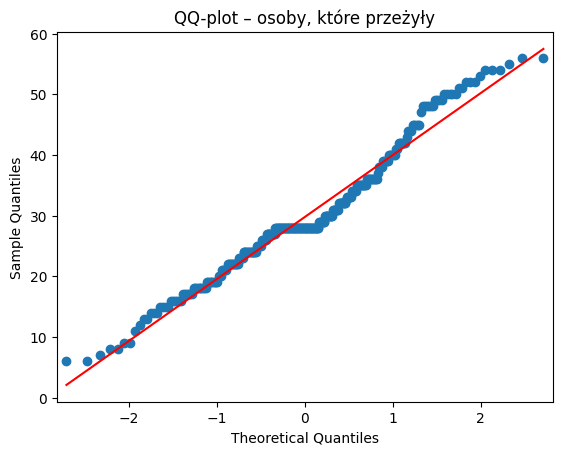

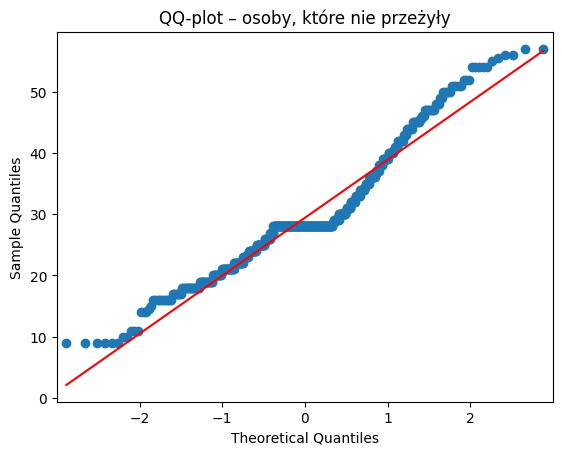

(SignificanceResult(statistic=np.float64(5.153906718102574), pvalue=np.float64(0.07600521223170789)),
 SignificanceResult(statistic=np.float64(9.066671764504889), pvalue=np.float64(0.010744772924394868)),
 SignificanceResult(statistic=np.float64(97.01671543634882), pvalue=np.float64(8.572113580466254e-22)),
 SignificanceResult(statistic=np.float64(45.48944839724026), pvalue=np.float64(1.3246214643255548e-10)))

In [98]:
# 6. Test parametryczny – test t-Studenta
# Hipoteza H0: średni wiek osób, które przeżyły = średni wiek osób, które nie przeżyły


# Usunięcie outlierów
def remove_outliers_iqr(series):
    Q1 = series.quantile(0.35)
    Q3 = series.quantile(0.80)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return series[(series >= lower_bound) & (series <= upper_bound)]


age_survived = df[df['Survived'] == 1]['Age']
age_dead = df[df['Survived'] == 0]['Age']

age_survived_clean = remove_outliers_iqr(age_survived)
age_dead_clean = remove_outliers_iqr(age_dead)

jb_survived = stats.jarque_bera(age_survived)
jb_dead = stats.jarque_bera(age_dead)

import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.qqplot(age_survived_clean, line='s')
plt.title("QQ-plot – osoby, które przeżyły")
plt.show()

sm.qqplot(age_dead_clean, line='s')
plt.title("QQ-plot – osoby, które nie przeżyły")
plt.show()

jb_survived_clean = stats.jarque_bera(age_survived_clean)
jb_dead_clean = stats.jarque_bera(age_dead_clean)

jb_survived,jb_survived_clean, jb_dead,jb_dead_clean


In [ ]:
alpha = 0.05

# Test t-Studenta z korektą Welcha
t_stat, p_value = stats.ttest_ind(
    age_survived,
    age_dead,
    equal_var=False
)

# Statystyki opisowe
mean_survived = np.mean(age_survived)
mean_dead = np.mean(age_dead)
std_survived = np.std(age_survived, ddof=1)
std_dead = np.std(age_dead, ddof=1)

print("TEST t-STUDENTA (Welch)")
print("-" * 40)
print(f"Średni wiek (przeżyli): {mean_survived:.2f}")
print(f"Średni wiek (nie przeżyli): {mean_dead:.2f}")
print(f"Statystyka t = {t_stat:.4f}")
print(f"p-value = {p_value:.6f}")


TEST t-STUDENTA (Welch)
----------------------------------------
Średni wiek (przeżyli): 28.16
Średni wiek (nie przeżyli): 30.03
Statystyka t = -2.0411
p-value = 0.041628


np.float64(30.028233151183972)

In [104]:
u_stat, p_value = stats.mannwhitneyu(
    age_survived,
    age_dead,
    alternative='two-sided'
)
# Mediany (lepsze miary dla testu nieparametrycznego)
median_survived = np.median(age_survived)

median_dead = np.median(age_dead)

print("TEST U MANNA–WHITNEYA")
print("-" * 40)
print(f"Mediana wieku (przeżyli): {median_survived:.2f}")
print(f"Mediana wieku (nie przeżyli): {median_dead:.2f}")
print(f"Statystyka U = {u_stat:.2f}")
print(f"p-value = {p_value:.6f}")

if p_value < 0.05:
    print(
        "\nWniosek: Odrzucamy hipotezę zerową.\n"
        "Istnieje istotna statystycznie różnica rozkładów wieku\n"
        "pomiędzy osobami, które przeżyły, a osobami, które nie przeżyły."
    )
else:
    print(
        "\nWniosek: Brak podstaw do odrzucenia hipotezy zerowej.\n"
        "Nie stwierdzono istotnej statystycznie różnicy rozkładów wieku."
    )

TEST U MANNA–WHITNEYA
----------------------------------------
Mediana wieku (przeżyli): 28.00
Mediana wieku (nie przeżyli): 28.00
Statystyka U = 88808.50
p-value = 0.221537

Wniosek: Brak podstaw do odrzucenia hipotezy zerowej.
Nie stwierdzono istotnej statystycznie różnicy rozkładów wieku.
